# Monte Carlo Dispersion Analysis with the Dispersion Class


Finally the Monte Carlo simulations can be performed using a dedicated class called Dispersion.
Say goodbye to the long and tedious process of creating the Monte Carlo Simulations throughout jupyter notebooks!


In [1]:
%load_ext autoreload
%autoreload 2

First, let's import the necessary libraries, including the newest Dispersion class!


In [2]:
from rocketpy import Environment, SolidMotor, Rocket, Flight, Dispersion
from rocketpy.monte_carlo import (
    McEnvironment,
    McSolidMotor,
    McRocket,
    McFlight,
    McNoseCone,
    McTail,
    McTrapezoidalFins,
    McParachute,
)
import datetime


If you are using Jupyter Notebooks, it is recommended to run the following line to make matplotlib plots which will be shown later interactive and higher quality.


In [3]:
%matplotlib inline

The Dispersion class allows us to perform Monte Carlo Simulations in a very simple way.
We just need to create an instance of the class, and then call the method `run_dispersion()` to perform the simulations.
The class has a lot of capabilities, but we will only use a few of them in this example.
We encourage you to check the documentation of the class to learn more about the Dispersion.

Also, you can check RocketPy's main reference for a better conceptual understanding
of the Monte Carlo Simulations: [RocketPy: Six Degree-of-Freedom Rocket Trajectory Simulator](<https://doi.org/10.1061/(ASCE)AS.1943-5525.0001331>)

TODO: improve the description


## First Step: Creating the Inputs for the Simulations


### Environment


In [4]:
env = Environment(
    railLength=5.7, latitude=39.389700, longitude=-8.288964, elevation=113
)

tomorrow = datetime.date.today() + datetime.timedelta(days=1)

env.setDate((tomorrow.year, tomorrow.month, tomorrow.day, 12))  # Hour given in UTC time

env.setAtmosphericModel(type="Ensemble", file="GEFS")


TODO: Improve docs
Here we only add a standard deviation to rail length of 0.005


In [5]:
mc_env = McEnvironment(
    environment=env,
    railLength=0.0005,
    ensembleMember = [0,1,2,20],
    windXFactor=(1,0.3,'normal'),
    windYFactor=(0.8,0.3)
)

mc_env

# TODO: improve the print or __repr__() of these Monte Carlo classes


McEnvironment(railLength=(5.7, 0.0005), date=[datetime.datetime(2023, 3, 16, 12, 0, tzinfo=<UTC>)], elevation=(113, 0), gravity=(9.80665, 0), latitude=(39.3897, 0), longitude=(-8.288964, 0), ensembleMember=[0, 1, 2, 20], windXFactor=(1, 0.3, 'normal'), windYFactor=(0.8, 0.3), datum=['SIRGAS2000'], timeZone=['UTC'])

### Motor


Let's define the motor using the firs method. We will be using the data from the manufacturer, and following
the [RocketPy's documentation](https://docs.rocketpy.org/en/latest/user/index.html).


In [6]:
motor = SolidMotor(
    thrustSource="dispersion_analysis_inputs/thrustCurve.csv",
    burnOutTime=5.274,
    grainsCenterOfMassPosition=-0.571,
    grainNumber=5,
    grainSeparation=6 / 1000,
    grainDensity=1707,
    grainOuterRadius=21.4 / 1000,
    grainInitialInnerRadius=9.65 / 1000,
    grainInitialHeight=120 / 1000,
    nozzleRadius=21.642 / 1000,
    throatRadius=8 / 1000,
    interpolationMethod="linear",
    nozzlePosition=-1.024,
    coordinateSystemOrientation="nozzleToCombustionChamber",
)

In [7]:
mc_motor = McSolidMotor(
    solidMotor=motor,
    burnOutTime=(5.274, 1),
    grainsCenterOfMassPosition=0.001,
    grainDensity=50,
    grainSeparation=1 / 1000,
    grainInitialHeight=1 / 1000,
    grainInitialInnerRadius=0.375 / 1000,
    grainOuterRadius=0.375 / 1000,
    totalImpulse=(1415.15, 35.3),
    throatRadius=0.5 / 1000,
    nozzleRadius=0.5 / 1000,
    nozzlePosition=0.001,
)
mc_motor

McSolidMotor(thrustSource=['dispersion_analysis_inputs/thrustCurve.csv'], burnOutTime=(5.274, 1), grainsCenterOfMassPosition=(-0.571, 0.001), grainNumber=[5], grainDensity=(1707, 50), grainOuterRadius=(0.0214, 0.000375), grainInitialInnerRadius=(0.00965, 0.000375), grainInitialHeight=(0.12, 0.001), grainSeparation=(0.006, 0.001), totalImpulse=(1415.15, 35.3), nozzleRadius=(0.021641999999999998, 0.0005), nozzlePosition=(-1.024, 0.001), throatRadius=(0.008, 0.0005))

### Rocket


In [8]:
rocket = Rocket(
    radius=40.45 / 1000,
    mass= 8.257,
    inertiaI=3.675,
    inertiaZ=0.007,
    powerOffDrag="dispersion_analysis_inputs/Cd_PowerOff.csv",
    powerOnDrag="dispersion_analysis_inputs/Cd_PowerOn.csv",
    centerOfDryMassPosition=0,
    coordinateSystemOrientation="tailToNose",
)

rocket.setRailButtons([0.2, -0.5])

rocket.addMotor(motor, position=-1.024)

nose_cone = rocket.addNose(length=0.274, kind="vonKarman", position=1.134+0.274)

fin_set = rocket.addTrapezoidalFins(
    n=3,
    rootChord=0.058,
    tipChord=0.018,
    span=0.077,
    position=-0.906,
)

# tail = rocket.addTail(
#     topRadius=0.0635, bottomRadius=0.0435, length=0.060, position=-1.194656
# )


Additionally, we set parachutes for our Rocket, as well as the trigger functions for the deployment of such parachutes.


In [9]:
def drogueTrigger(p, y):
    # p = pressure
    # y = [x, y, z, vx, vy, vz, e0, e1, e2, e3, w1, w2, w3]
    # activate drogue when vz < 0 m/s.
    return True if y[5] < 0 else False


def mainTrigger(p, y):
    # p = pressure
    # y = [x, y, z, vx, vy, vz, e0, e1, e2, e3, w1, w2, w3]
    # activate main when vz < 0 m/s and z < 500 + 100 m (+100 due to surface elevation).
    return True if y[5] < 0 and y[2] < 500 + 100 else False


# main_chute = rocket.addParachute(
#     "Main",
#     CdS=10.0,
#     trigger=mainTrigger,
#     samplingRate=105,
#     lag=1.5,
#     noise=(0, 8.3, 0.5),
# )

drogue_chute = rocket.addParachute(
    "Drogue",
    CdS=0.349 * 1.3,
    trigger=drogueTrigger,
    samplingRate=105,
    lag=1,
    noise=(0, 8.3, 0.5),
)



In [10]:
mc_rocket = McRocket(
    rocket=rocket,
    radius=0.001,
    mass=0.001,
    inertiaI=0.03675,
    inertiaZ=0.00007,
    powerOffDragFactor=(0.9081 / 1.05,0.033),
    powerOnDragFactor=(0.9081 / 1.05,0.033),
)
mc_rocket

McRocket(radius=(0.04045, 0.001), mass=(8.257, 0.001), inertiaI=(3.675, 0.03675), inertiaZ=(0.007, 7e-05), powerOffDrag=[Function from R1 to R1 : (Mach Number) → (Drag Coefficient with Power Off)], powerOnDrag=[Function from R1 to R1 : (Mach Number) → (Drag Coefficient with Power On)], centerOfDryMassPosition=(0, 0), powerOffDragFactor=(0.8648571428571429, 0.033), powerOnDragFactor=(0.8648571428571429, 0.033))

In [11]:
mc_nose_cone = McNoseCone(
    nosecone=nose_cone,
    length=0.001,
)

mc_fin_set = McTrapezoidalFins(
    trapezoidalFins=fin_set,
    rootChord=0.0005,
    tipChord=0.0005,
    span=0.0005,
)

# mc_tail = McTail(
#     tail=tail,
#     topRadius=0.001,
#     bottomRadius=0.001,
#     length=0.001,
# )

# mc_main = McParachute(
#     parachute=main_chute,
#     CdS=0.1,
#     lag=0.1,
# )

mc_drogue = McParachute(
    parachute=drogue_chute,
    CdS=0.07,
    lag=0.5,
)

In [12]:
mc_rocket.addMotor(mc_motor,position=0.001)
mc_rocket.addNose(mc_nose_cone,position=(1.134,0.001))
mc_rocket.addTrapezoidalFins(mc_fin_set,position=(0.001,"normal"))
# mc_rocket.addTail(mc_tail,position=(-1.194656,0.001,"normal"))
# mc_rocket.addParachute(mc_main)
mc_rocket.addParachute(mc_drogue)

In [13]:
print(mc_rocket.motors[0].position)
print(mc_rocket.nosecones[0].position)
print(mc_rocket.fins[0].position)
# print(mc_rocket.tails[0].position)


(-1.024, 0.001)
(1.134, 0.001)
(-0.906, 0.001, 'normal')


### Flight


In [14]:
test_flight = Flight(
    rocket=rocket,
    environment=env,
    inclination=84,
    heading=133,
)


In [15]:
mc_flight = McFlight(
    flight=test_flight,
    inclination=(84.7, 1),
    heading=(53, 2),
)

And we can visualize the flight trajectory:


In [16]:
# test_flight.plots.trajectory_3d()


### Starting the Monte Carlo Simulations


First, let's invoke the Dispersion class, we only need a filename to initialize it.
The filename will be used either to save the results of the simulations or to load them
from a previous ran simulation.


In [17]:
test_dispersion = Dispersion(
    filename="dispersion_analysis_outputs/disp_class_example",
    environment=mc_env,
    rocket=mc_rocket,
    flight=mc_flight,
)

# TODO: add custom warning o when the rocket doesn't have a motors, parachute, or aerosurfaces


Then, we can run the simulations using the method Dispersion.run_dispersion().
But before that, we need to set some simple parameters for the simulations.
We will set them by using a dictionary, which is one of the simplest way to do it.


Finally, let's iterate over the simulations and export the data from each flight simulation!


In [45]:
with open("dispersion_analysis_outputs/disp_class_example.disp_outputs.txt") as f:
    a = f.readline()
json.load(a)

AttributeError: 'str' object has no attribute 'read'

In [43]:
import json
with open("dispersion_analysis_outputs/disp_class_example.disp_outputs.txt") as f:
    a = [json.loads(line) for line in f.readline()]
a

JSONDecodeError: Expecting property name enclosed in double quotes: line 1 column 2 (char 1)

In [33]:
test_dispersion.run_dispersion(
    number_of_simulations=50,
    append=True,
)

UnsupportedOperation: not readable

In [23]:
# In case you want to verify the new dispersion dictionary format...
test_dispersion.dispersion_dictionary


{'environment': {'railLength': (5.7, 0.0005, <function RandomState.normal>),
  'date': [datetime.datetime(2023, 3, 16, 12, 0, tzinfo=<UTC>)],
  'elevation': (113, 0, <function RandomState.normal>),
  'gravity': (9.80665, 0, <function RandomState.normal>),
  'latitude': (39.3897, 0, <function RandomState.normal>),
  'longitude': (-8.288964, 0, <function RandomState.normal>),
  'ensembleMember': [0, 1, 2, 20],
  'windXFactor': (1, 0.3, <function RandomState.normal>),
  'windYFactor': (0.8, 0.3, <function RandomState.normal>),
  'datum': ['SIRGAS2000'],
  'timeZone': ['UTC']},
 'rocket': {'radius': (0.04045, 0.001, <function RandomState.normal>),
  'mass': (8.257, 0.001, <function RandomState.normal>),
  'inertiaI': (3.675, 0.03675, <function RandomState.normal>),
  'inertiaZ': (0.007, 7e-05, <function RandomState.normal>),
  'powerOffDrag': [Function from R1 to R1 : (Mach Number) → (Drag Coefficient with Power Off)],
  'powerOnDrag': [Function from R1 to R1 : (Mach Number) → (Drag Coeffi

### Visualizing the results


Now we finally have the results of our Monte Carlo simulations loaded!
Let's play with them.


First, we can print numerical information regarding the results of the simulations.


In [24]:
test_dispersion.import_results()


A total of 500 simulations were loaded from the following file: dispersion_analysis_outputs/disp_class_example.disp_outputs.txt


In [25]:
test_dispersion.print_results()


apogee: μ = 962.098, σ = 41.089
apogeeTime: μ = 14.237, σ = 0.352
apogeeX: μ = 125.484, σ = 22.928
apogeeY: μ = 70.064, σ = 19.037
apogeeFreestreamSpeed: μ = 8.208, σ = 1.524
tFinal: μ = 65.750, σ = 4.418
xImpact: μ = 197.234, σ = 34.009
yImpact: μ = 306.344, σ = 52.929
impactVelocity: μ = -17.521, σ = 1.427
initialStaticMargin: μ = 3.195, σ = 0.105
finalStaticMargin: μ = 4.070, σ = 0.114
outOfRailStaticMargin: μ = 3.372, σ = 0.105
outOfRailTime: μ = 1.125, σ = 0.192
outOfRailVelocity: μ = 27.173, σ = 3.684
maxSpeed: μ = 126.260, σ = 5.687
maxMachNumber: μ = 0.370, σ = 0.017
maxAcceleration: μ = 115.071, σ = 27.682
frontalSurfaceWind: μ = 1.418, σ = 0.330
lateralSurfaceWind: μ = 2.182, σ = 0.429
executionTime: μ = 0.335, σ = 0.051


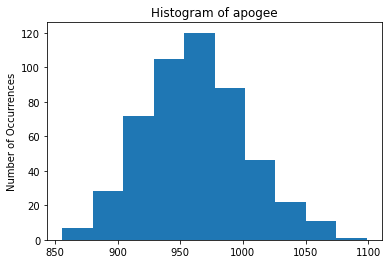

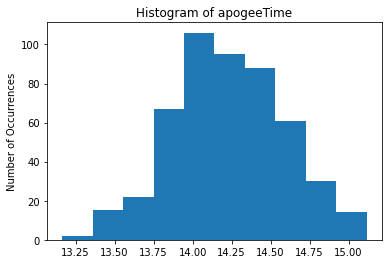

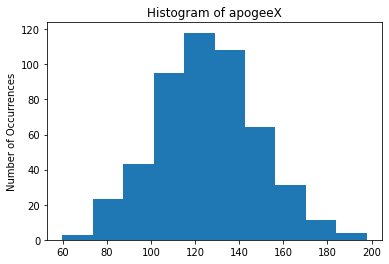

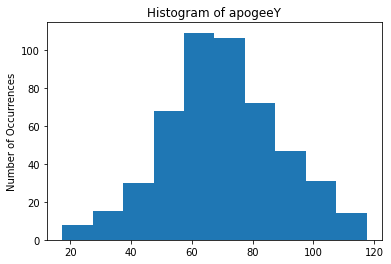

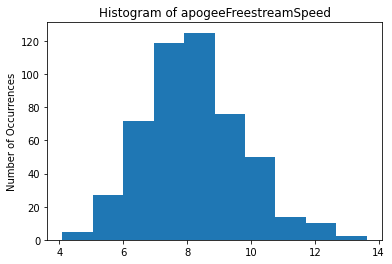

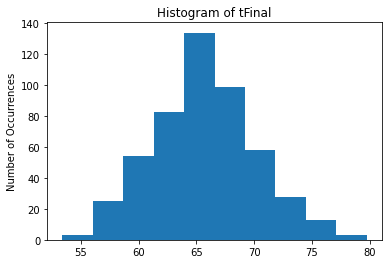

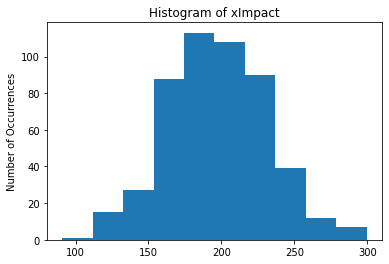

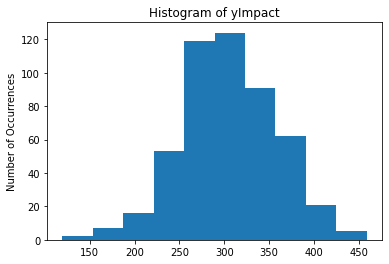

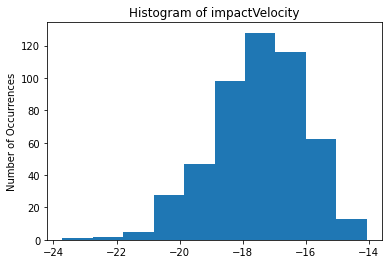

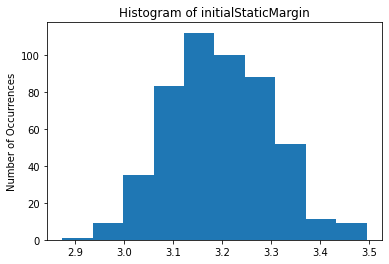

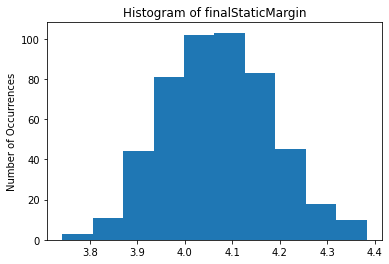

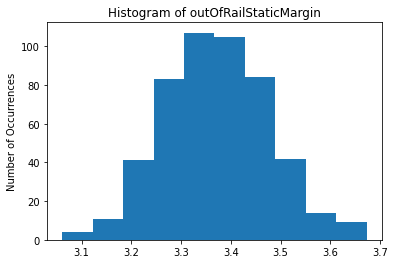

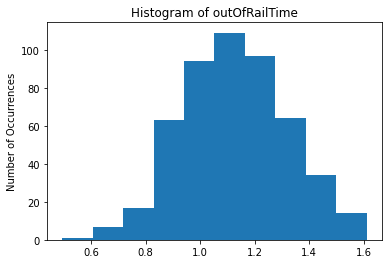

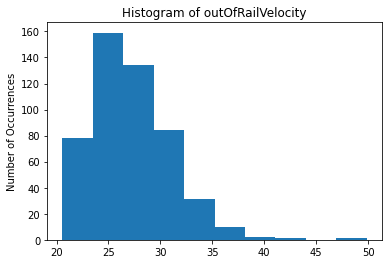

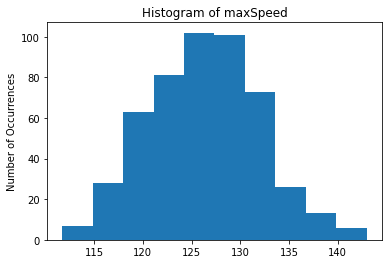

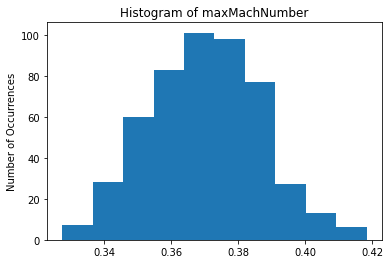

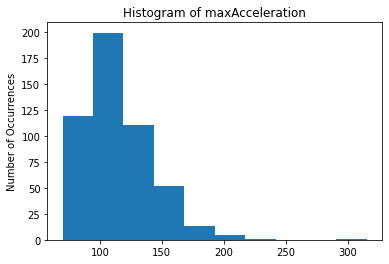

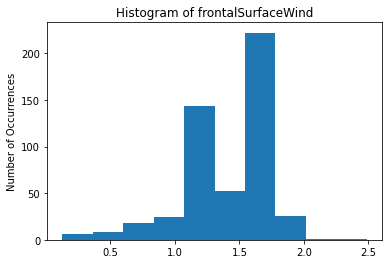

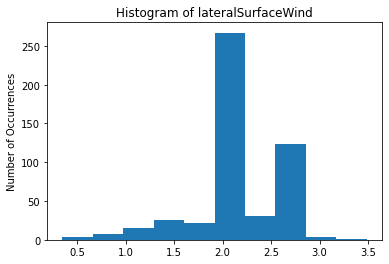

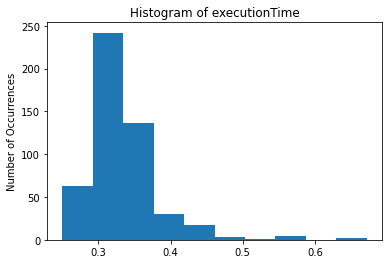

In [29]:
test_dispersion.plot_results()

Also, we can visualize histograms of such results


Monte Carlo Simulation by RocketPy
Data Source:  dispersion_analysis_outputs/disp_class_example
Number of simulations:  500
Results: 
apogee: μ = 962.098, σ = 41.089
apogeeTime: μ = 14.237, σ = 0.352
apogeeX: μ = 125.484, σ = 22.928
apogeeY: μ = 70.064, σ = 19.037
apogeeFreestreamSpeed: μ = 8.208, σ = 1.524
tFinal: μ = 65.750, σ = 4.418
xImpact: μ = 197.234, σ = 34.009
yImpact: μ = 306.344, σ = 52.929
impactVelocity: μ = -17.521, σ = 1.427
initialStaticMargin: μ = 3.195, σ = 0.105
finalStaticMargin: μ = 4.070, σ = 0.114
outOfRailStaticMargin: μ = 3.372, σ = 0.105
outOfRailTime: μ = 1.125, σ = 0.192
outOfRailVelocity: μ = 27.173, σ = 3.684
maxSpeed: μ = 126.260, σ = 5.687
maxMachNumber: μ = 0.370, σ = 0.017
maxAcceleration: μ = 115.071, σ = 27.682
frontalSurfaceWind: μ = 1.418, σ = 0.330
lateralSurfaceWind: μ = 2.182, σ = 0.429
executionTime: μ = 0.335, σ = 0.051
Plotting results: 


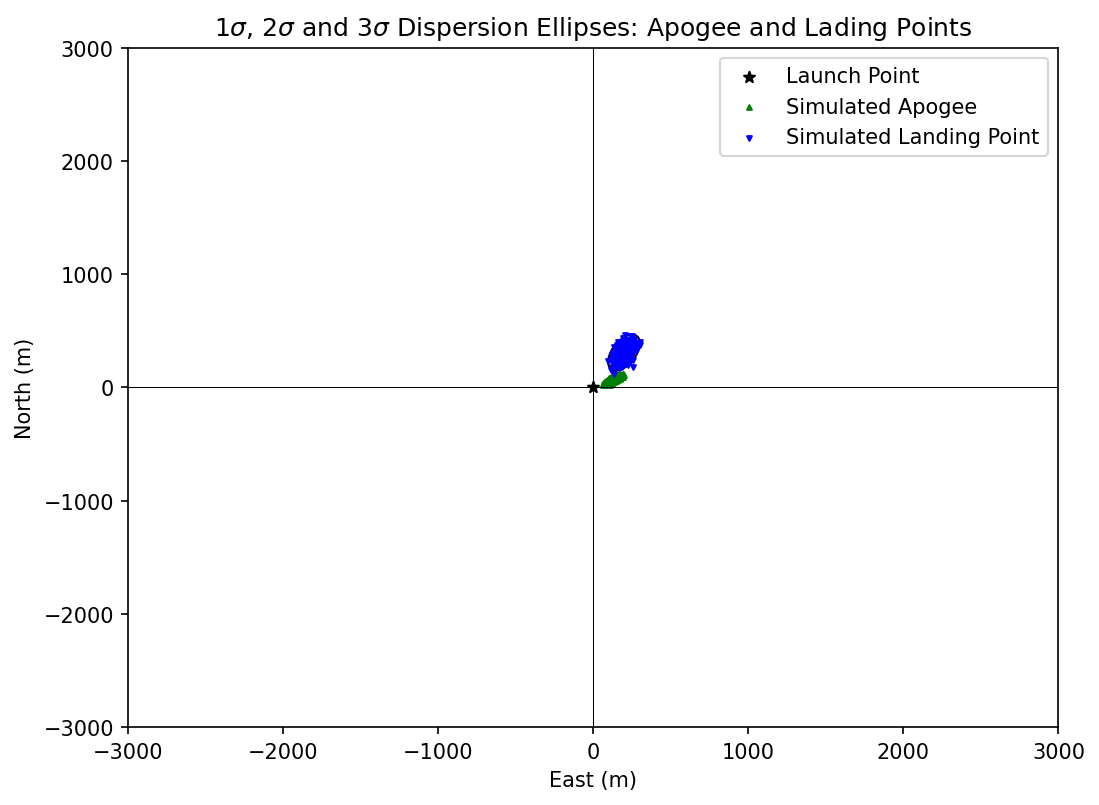

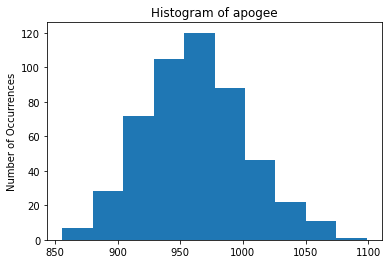

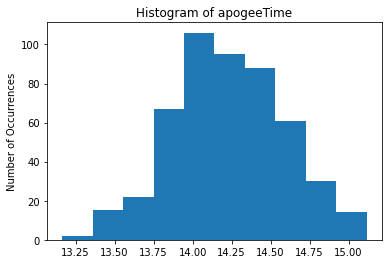

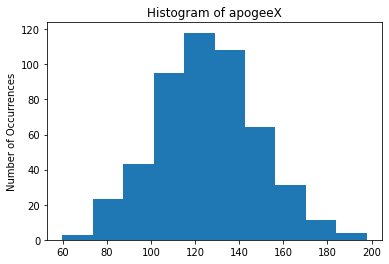

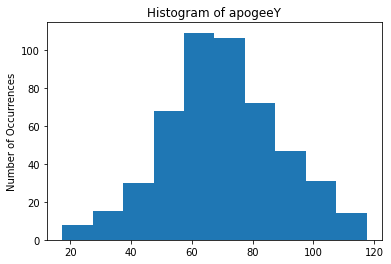

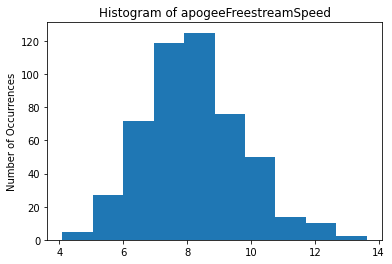

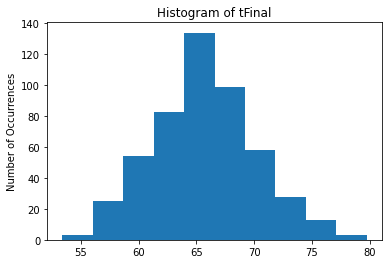

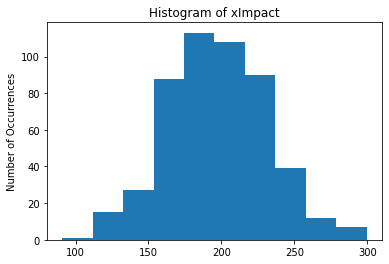

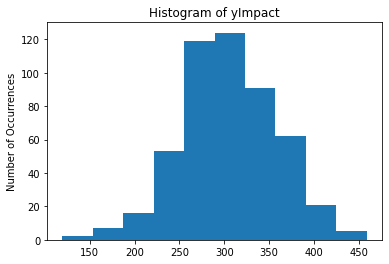

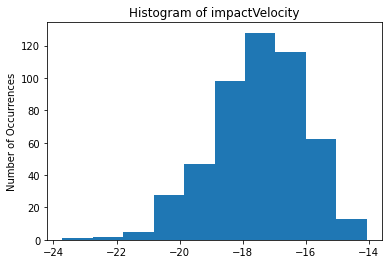

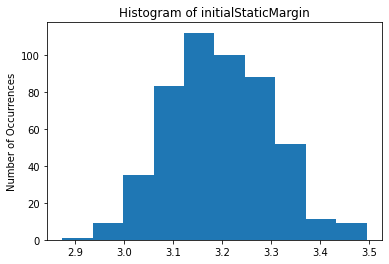

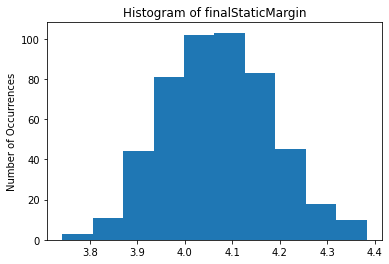

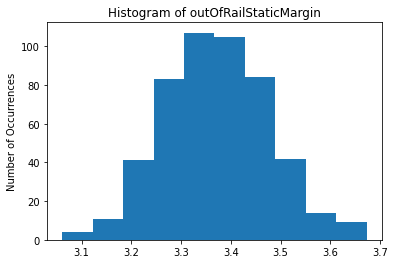

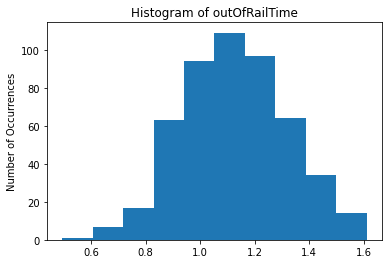

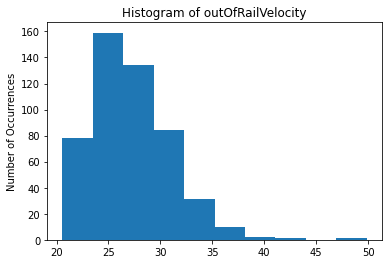

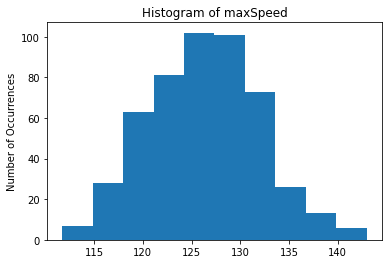

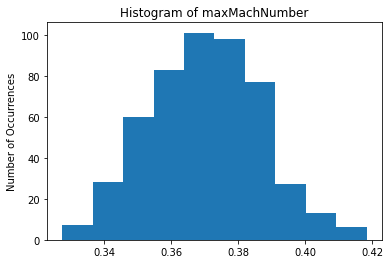

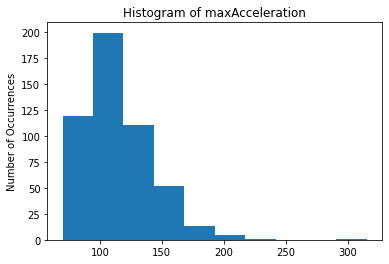

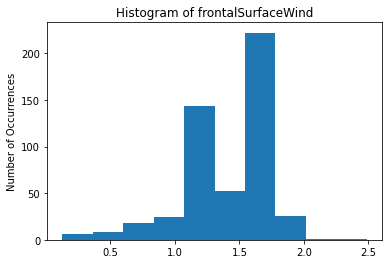

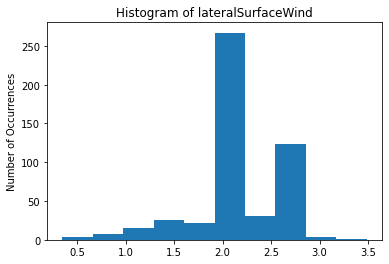

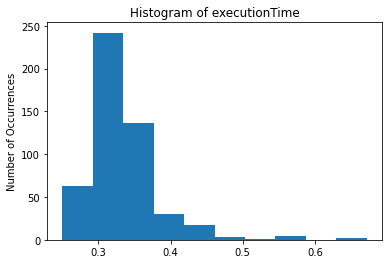

In [26]:
test_dispersion.allInfo()


Export to kml so it can be visualized in Google Earth


In [ ]:
test_dispersion.exportEllipsesToKML(
    filename="dispersion_analysis_outputs/disp_class_example.kml",
    origin_lat=env.latitude,
    origin_lon=env.longitude,
    type="impact",
)
